<a href="https://colab.research.google.com/github/lucasfelipecdm/tech-challenge-fase-1/blob/develop/modeling/model_building_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento e validação do modelo

Nessa fase faremos o treinamento do nosso modelo utilizando a [tabela pré-processada](https://raw.githubusercontent.com/lucasfelipecdm/tech-challenge-fase-1/develop/data/dataset_preprocessed.csv) durante nossa última [fase](https://github.com/lucasfelipecdm/tech-challenge-fase-1/blob/develop/preprocessing/data_preprocessing.ipynb) começaremos pela separação da base pré-processada em base de treino e teste.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import os

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
plt.figure(figsize=(10,5))

preprocessed_dataset_url = "https://raw.githubusercontent.com/lucasfelipecdm/tech-challenge-fase-1/develop/data/preprocessed.csv"
dataset_preprocessed = pd.read_csv(preprocessed_dataset_url)
dataset_preprocessed.drop(['lines'], axis = 1, inplace = True)
dataset_preprocessed.head(5)

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


<Figure size 1000x500 with 0 Axes>

In [3]:
dataset_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 62.8 KB


### Separação das tabelas e remoção da coluna target

Nesse passo vamos separar em tabelas X e y nossa variavel target e nossa tabela com as outras variáveis

In [4]:
X = dataset_preprocessed.drop("charges", axis = 1)
y = dataset_preprocessed.charges

#### Separação entre treino e teste

Aqui usamos o metódo `train_test_split` do sklearn para separarmos nossas base de dados em tabelas de treino e teste.

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Feature Scaling ( Normalização e Padronização dos dados )

Aqui utilizaremos um metódo também do sklearn para padronização dos dados deixando eles em uma mesma escala para que valores com maior peso não tenha impacto e crie viés em nosso modelo.

In [6]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_train

array([[ 1.54446486, -1.02597835,  0.10596012, -0.91501097, -0.51298918],
       [ 0.48187425,  0.97467943, -0.49198238, -0.91501097, -0.51298918],
       [ 1.04858924, -1.02597835,  0.23025154,  1.56027883, -0.51298918],
       ...,
       [ 1.33194673,  0.97467943, -0.89928872, -0.91501097, -0.51298918],
       [-0.15568012, -1.02597835,  2.81517714,  0.73518223,  1.94935887],
       [ 1.11942861,  0.97467943, -0.10567121, -0.91501097, -0.51298918]])

Apenas aplicaremos o `.fit_transform` na base de treinamento e não na base de teste.

In [7]:
X_test = standard_scaler.transform(X_test)
X_test

array([[ 0.41103487, -1.02597835, -0.89928872,  0.73518223, -0.51298918],
       [-0.22651949, -1.02597835, -0.08551585, -0.91501097, -0.51298918],
       [ 1.75698298, -1.02597835, -0.61207477, -0.91501097,  1.94935887],
       ...,
       [-1.50162823, -1.02597835, -0.38868613, -0.91501097, -0.51298918],
       [ 1.33194673,  0.97467943,  0.9323301 , -0.91501097, -0.51298918],
       [-1.35994948,  0.97467943, -1.4325661 , -0.08991437, -0.51298918]])

### Criação do modelo

Agora criaremos o modelo e testaremos alguns tipos de regressão, para ser mais exato utilizaremos 5 tipos de regressão, sendo elas: Multi Linear, Floresta Aleatória, Árvore de decisão, XG Boost e Aumento Gradiente:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


Também importaremos alguns metódos que nos ajudaram na avaliação dos resultados do modelo.

In [9]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

Adicionaremos uma função para calculo do MAPE ( Mean Absolute Percentage Error )

In [10]:
def calculate_mape(real, pred):
    errors = np.abs(real - pred)
    relative_errors = errors / np.abs(real)
    mape = np.mean(relative_errors) * 100
    return mape

Vamos criar um dicionário para salvar os resultados de cada tipo de regressão

In [11]:
from collections import OrderedDict
model_rmse = OrderedDict()
model_r2 = OrderedDict()
model_mape = OrderedDict()

#### Regressão Multi Linear

In [12]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_value = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

model_rmse['Multi Linear Regression'] = round(rmse, 3)
model_r2['Multi Linear Regression'] = round(r2_value, 3)
model_mape['Multi Linear Regression'] = round(mape, 3)

#### Regressão por Árvore de Decisão

In [13]:
decision_tree_regressor = DecisionTreeRegressor()
decision_tree_regressor.fit(X_train, y_train)

y_pred = decision_tree_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_value = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

model_rmse['Decision Tree Regression'] = round(rmse, 3)
model_r2['Decision Tree Regression'] = round(r2_value, 3)
model_mape['Decision Tree Regression'] = round(mape, 3)

#### Regressão por Floresta Aleatória

In [14]:
random_forest_regressor = RandomForestRegressor(n_estimators = 1000, random_state = 27)
random_forest_regressor.fit(X_train, y_train)

y_pred = random_forest_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_value = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

model_rmse['Random Forest Regression'] = round(rmse, 3)
model_r2['Random Forest Regression'] = round(r2_value, 3)
model_mape['Random Forest Regression'] = round(mape, 3)

#### Regressão XGBoost

In [15]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_value = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

model_rmse['XGBoost Regression'] = round(rmse, 3)
model_r2['XGBoost Regression'] = round(r2_value, 3)
model_mape['XGBoost Regression'] = round(mape, 3)

#### Regressão por Aumento Gradiente

In [16]:
gradient_boosting_regressor = GradientBoostingRegressor(n_estimators=100, random_state=23)
gradient_boosting_regressor.fit(X_train, y_train)

y_pred = gradient_boosting_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_value = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

model_rmse['Gradient Boosting Regression'] = round(rmse, 3)
model_r2['Gradient Boosting Regression'] = round(r2_value, 3)
model_mape['Gradient Boosting Regression'] = round(mape, 3)

#### Resultados dos modelos de regressão

Agora olharemos os resultados dos modelos de regressão em forma de tabela

In [17]:
from tabulate import tabulate
table = []
table.append(['S.No.', 'Regression Model', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R-squared'])
count = 1

for model in model_rmse:
    row = [count, model, model_rmse[model], model_mape[model], model_r2[model]]
    table.append(row)
    count += 1

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════╤══════════════════════════════╤═══════════════════════════╤══════════════════════════════════╤═════════════╕
│   S.No. │ Regression Model             │   Root Mean Squared Error │   Mean Absolute Percentage Error │   R-squared │
╞═════════╪══════════════════════════════╪═══════════════════════════╪══════════════════════════════════╪═════════════╡
│       1 │ Multi Linear Regression      │                   4955.23 │                           39.017 │       0.762 │
├─────────┼──────────────────────────────┼───────────────────────────┼──────────────────────────────────┼─────────────┤
│       2 │ Decision Tree Regression     │                   5680.47 │                           35.61  │       0.687 │
├─────────┼──────────────────────────────┼───────────────────────────┼──────────────────────────────────┼─────────────┤
│       3 │ Random Forest Regression     │                   4453.52 │                           31.66  │       0.808 │
├─────────┼─────────────────────────────

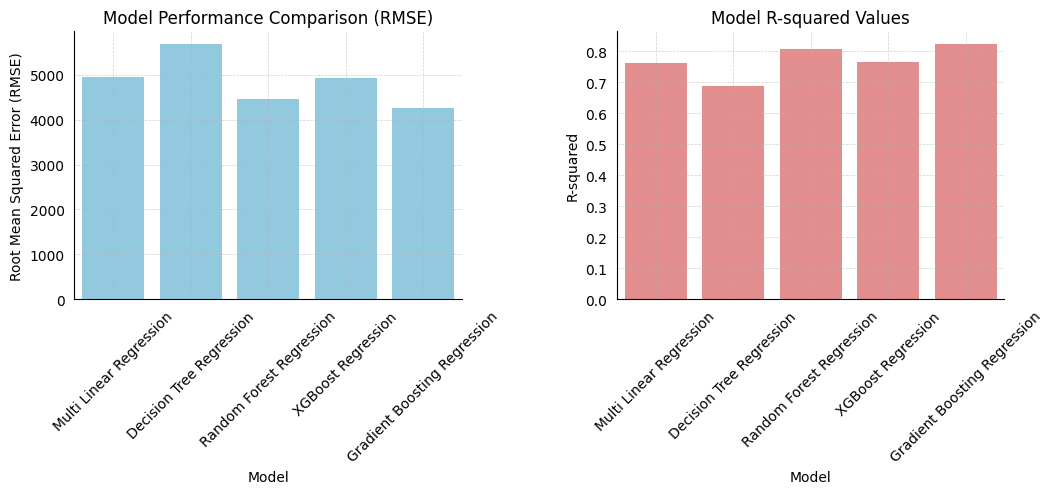

In [37]:
plt.figure(figsize=(12, 8))
gridspec = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(gridspec[0, 0])
sns.barplot(x=model_rmse.keys(), y=model_rmse.values(), ax=ax1, color='skyblue')
ax1.set_title('Model Performance Comparison (RMSE)', fontsize=12)
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=10)
plt.xticks(rotation=45)

ax2 = plt.subplot(gridspec[0, 1])
sns.barplot(x=model_r2.keys(), y=model_r2.values(), ax=ax2, color='lightcoral')
ax2.set_title('Model R-squared Values', fontsize=12)
ax2.set_xlabel('Model', fontsize=10)
ax2.set_ylabel('R-squared', fontsize=10)
plt.xticks(rotation=45)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.grid(True, linestyle='--', alpha=0.6, which='both', linewidth=0.5)

plt.tight_layout()

plt.show()

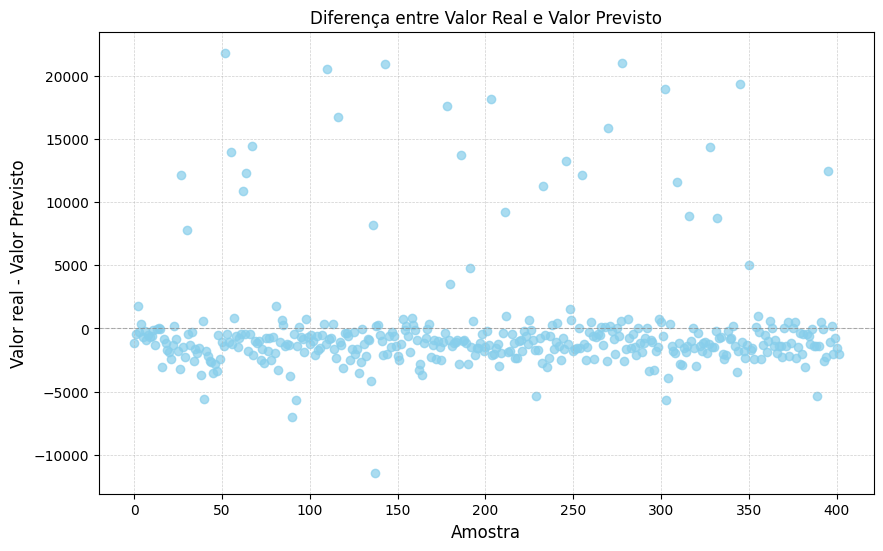

In [27]:
plt.figure(figsize=(10, 6))
plt.title('Diferença entre Valor Real e Valor Previsto')

plt.scatter(range(len(y_test)), y_test - y_pred, color='skyblue', alpha=0.7)
plt.xlabel('Amostra')
plt.ylabel('Valor real - Valor Previsto')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
plt.grid(True, linestyle='--', alpha=0.6, which='both', linewidth=0.5)

plt.show()

Podemos ver a diferença entre os valores reais e de predição no gráfico acime, em alguns casos temos um erro de mais de 20mil e em outros casos de -10mil.

Porém conseguimos visualizar a uma linha bem próxima do valor 0, tendo acertado a maior parte das predições.

# Resultados

Como podemos notar o modelo de regressão que teve o melhor desempenho foi o Gradient Boosting apresentando um RMSE de 4269.24 e um R2 de 0.823

Também podemos tirar como insight desse projeto:

 - Pessoas com IMC mais alto normalmente também são fumantes;
 - Pessoas com maior número de filhos são minoria na busca por plano de saúde, talvez devido ao aumento de custo;
